# 6.2 Exploring Relationships

## 1. Imports, Settings, and Loading the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pyarrow
import seaborn as sns
import warnings

In [3]:
project_path = r'C:\Users\cneva\Projects\NBA Shot Analysis'
df = pd.read_csv(os.path.join(project_path,'Datasets','NBA_Shot_Analysis.csv'))
pd.set_option("display.max_columns", None) # pd.reset_option("display.max_columns")
warnings.filterwarnings('ignore', category = FutureWarning) # Suppress seaborn specific future warnings

## 2. Correlation Matrix Heatmap

### a.) Relationship between shots_made and other variables

In [6]:
# Create a subset of the data 
# Correlation between shot made, and other variables that may contribute to increasing the likelihood of a shot scored
df_correlation = (df \
                  .loc[:, ['shot_made', 'salary', 'secs_left_in_quarter', 'shot_distance', 'position_group', 'zone_name']]
                  .assign(is_3PT_attempt = df['shot_type'].map({'3PT Field Goal': True, '2PT Field Goal': False}))
                 )

df_correlation.head()

,shot_made,salary,secs_left_in_quarter,shot_distance,position_group,zone_name,is_3PT_attempt
0,False,1000000,122,25,G,Right Side Center,True
1,False,1000000,593,23,G,Right Side,True
2,False,1000000,248,23,G,Right Side,True
3,True,1000000,61,1,G,Center,False
4,True,1000000,684,27,G,Right Side Center,True


In [7]:
from scipy.stats import pointbiserialr, chi2_contingency

dependent_variable = df['shot_made']

df_correlation_values = {}

def calc_correlation_continuous(independent_variable):
    df_correlation_values[independent_variable.name] = pointbiserialr(dependent_variable, independent_variable).correlation

def calc_correlation_boolean(independent_variable):
    df_correlation_values[independent_variable.name] = dependent_variable.astype(int).corr(independent_variable)

def calc_correlation_categorical(independent_variable):
    confusion_matrix = pd.crosstab(dependent_variable, independent_variable)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    df_correlation_values[independent_variable.name] =  np.sqrt(chi2 / (n * (min(r, k) - 1)))

calc_correlation_continuous(df_correlation['salary'])
calc_correlation_continuous(df_correlation['shot_distance'])
calc_correlation_continuous(df_correlation['secs_left_in_quarter'])
calc_correlation_boolean(df_correlation['is_3PT_attempt'])
calc_correlation_categorical(df_correlation['zone_name'])
calc_correlation_categorical(df_correlation['position_group'])

df_correlation_values = pd.DataFrame.from_dict(df_correlation_values, orient = 'index', columns = ['Correlation'])
df_correlation_values

,Correlation
salary,0.025250
shot_distance,-0.229424
secs_left_in_quarter,0.021668
is_3PT_attempt,-0.175766
zone_name,0.169703
position_group,0.072641


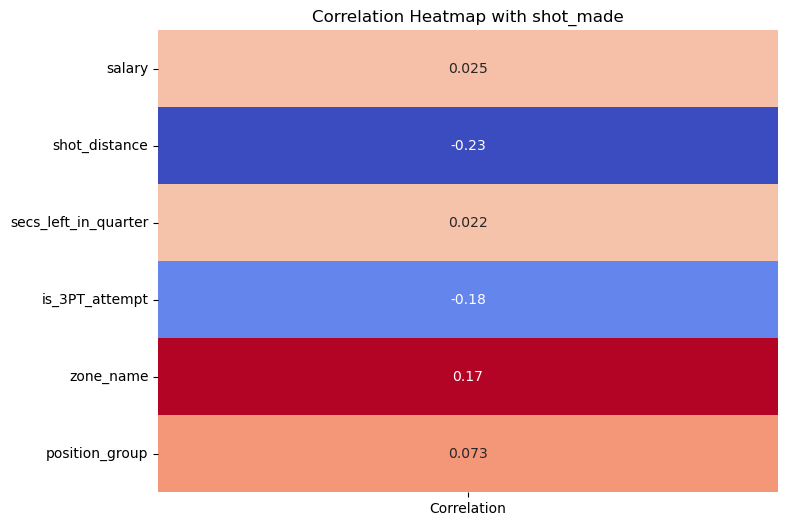

In [8]:
plt.figure(figsize = (8, 6))
sns.heatmap(df_correlation_values, annot = True, cmap = "coolwarm", cbar = False)
plt.title('Correlation Heatmap with shot_made')
plt.show()

-- Out of all the variables tested, shot_distance and is_3PT_attempt has the strongest (negative) correlation.  This makes sense as the further away from the basket, the less likely the shot will go in.

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
ohe = OneHotEncoder(handle_unknown = 'ignore',  sparse_output = False).set_output(transform = 'pandas')

In [12]:
zone_name_transform = ohe.fit_transform(df[['zone_name']])
zone_name_transform

,zone_name_Back Court,zone_name_Center,zone_name_Left Side,zone_name_Left Side Center,zone_name_Right Side,zone_name_Right Side Center
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
218696,0.0,0.0,0.0,0.0,1.0,0.0
218697,0.0,1.0,0.0,0.0,0.0,0.0
218698,0.0,1.0,0.0,0.0,0.0,0.0
218699,0.0,1.0,0.0,0.0,0.0,0.0


### b.) Relationship between Zones

In [14]:
df_zone_name_corr = (df \
                     .loc[:,['shot_made']]
                     .join(zone_name_transform)
                     .rename(columns = lambda col: col.replace('zone_name_', ''))
                    )
df_zone_name_corr

,shot_made,Back Court,Center,Left Side,Left Side Center,Right Side,Right Side Center
0,False,0.0,0.0,0.0,0.0,0.0,1.0
1,False,0.0,0.0,0.0,0.0,1.0,0.0
2,False,0.0,0.0,0.0,0.0,1.0,0.0
3,True,0.0,1.0,0.0,0.0,0.0,0.0
4,True,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
218696,True,0.0,0.0,0.0,0.0,1.0,0.0
218697,False,0.0,1.0,0.0,0.0,0.0,0.0
218698,True,0.0,1.0,0.0,0.0,0.0,0.0
218699,True,0.0,1.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Correlation Heatmap - Zone Name')

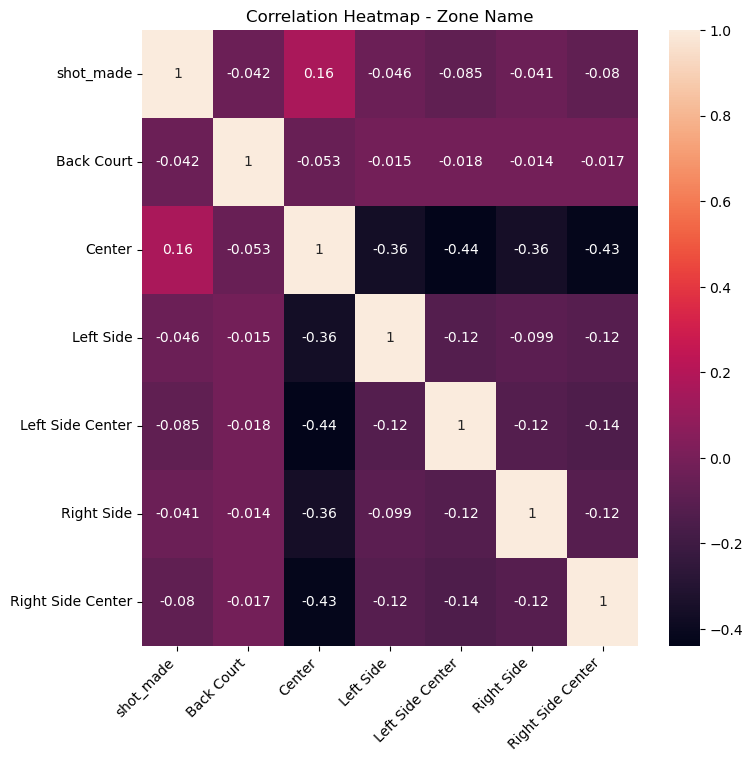

In [15]:
f,ax = plt.subplots(figsize=(8,8))
corr = sns.heatmap(df_zone_name_corr.corr(), annot = True, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title("Correlation Heatmap - Zone Name")

### c.) Relationship between Positions

In [17]:
position_group_transform = ohe.fit_transform(df[['position_group']])
position_group_transform

,position_group_C,position_group_F,position_group_G
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
218696,0.0,1.0,0.0
218697,0.0,1.0,0.0
218698,0.0,1.0,0.0
218699,0.0,1.0,0.0


In [18]:
df_position_group_corr = (df \
                     .loc[:,['shot_made']]
                     .join(position_group_transform)
                     .rename(columns = lambda col: col.replace('position_group_', ''))
                    )
df_position_group_corr

,shot_made,C,F,G
0,False,0.0,0.0,1.0
1,False,0.0,0.0,1.0
2,False,0.0,0.0,1.0
3,True,0.0,0.0,1.0
4,True,0.0,0.0,1.0
...,...,...,...,...
218696,True,0.0,1.0,0.0
218697,False,0.0,1.0,0.0
218698,True,0.0,1.0,0.0
218699,True,0.0,1.0,0.0


Text(0.5, 1.0, 'Correlation Heatmap - Position Group')

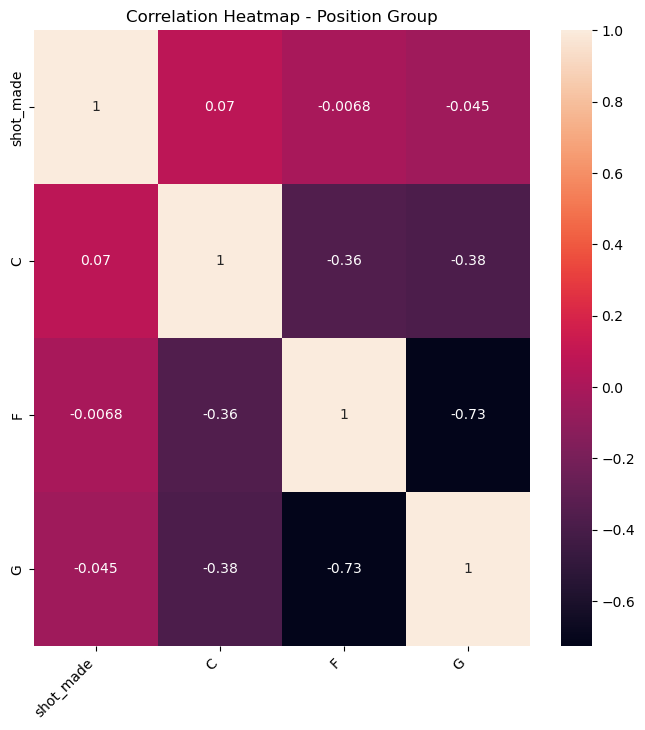

In [19]:
f,ax = plt.subplots(figsize=(8,8))
corr = sns.heatmap(df_position_group_corr.corr(), annot = True, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title("Correlation Heatmap - Position Group")

## 3. Scatterplot

In [21]:
df_scatter = (
    df.loc[:, ['player_team_name', 'player_name', 'salary', 'position_group', 'shot_made']]
    .groupby(['player_team_name', 'player_name', 'salary', 'position_group'])  # Include team for later total shots
    .agg(
        field_goal_perc = ('shot_made', 'mean'),
        shots_attempted = ('shot_made', 'count')
    )
    .reset_index()
    .assign(
        field_goal_perc = lambda df: df.field_goal_perc.multiply(100).round(1),
        team_total_shots = lambda df: df.groupby('player_team_name')['shots_attempted'].transform('sum'),
        team_shot_perc = lambda df: (df['shots_attempted'] / df['team_total_shots'] * 100).round(1)
    )
    .drop(columns = ['team_total_shots','player_team_name'])
)

df_scatter.sample(10)

,player_name,salary,position_group,field_goal_perc,shots_attempted,team_shot_perc
169,Isaiah Stewart,5266713,F,48.7,382,5.3
457,Jalen Suggs,7252080,G,47.1,714,10.3
28,Jrue Holiday,37620347,G,48.0,689,9.3
63,Cody Martin,7560000,F,38.1,215,3.0
239,Kendall Brown,1100000,G,53.3,15,0.2
259,Moussa Diabate,559782,C,52.6,19,0.3
456,Goga Bitadze,2066585,C,60.3,209,3.0
7,Garrison Mathews,2000000,G,45.6,226,3.0
133,Josh Green,4765339,G,47.9,374,5.1
630,Danilo Gallinari,7850062,F,43.5,131,1.7


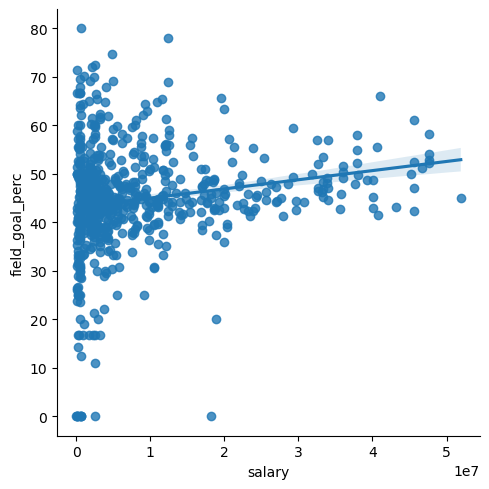

In [22]:
sns.lmplot(x = 'salary', y = 'field_goal_perc', data = df_scatter)

There seems to be a slight correlation between the chance of a field goal and the player's salary as the salary goes up.

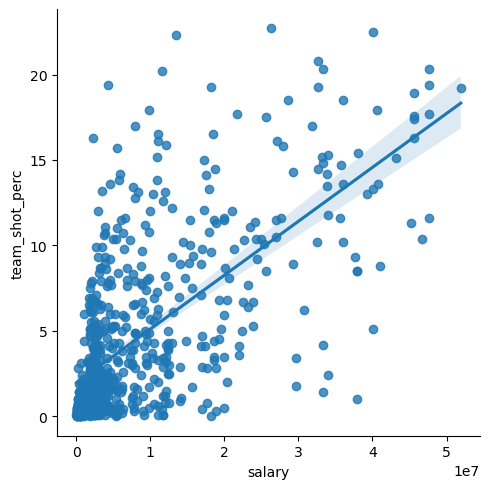

In [23]:
sns.lmplot(x = 'salary', y = 'team_shot_perc', data = df_scatter)

There's a more pronounced but less clustered correlation between the number of shots a player contributes to the team versus their salary.  This may suggest that star players will shoot the ball more than other's on their team.

## 4. Category Plot

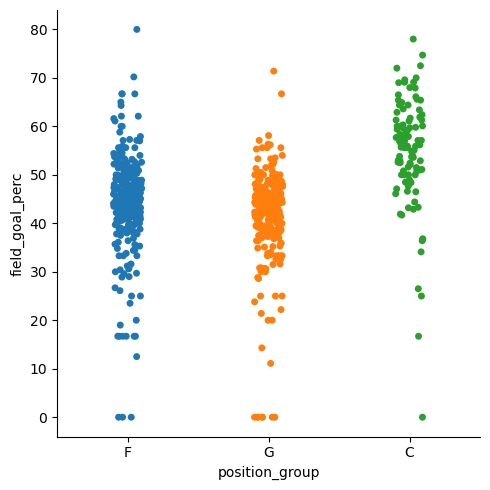

In [25]:
shot_perc_by_position = sns.catplot(x = "position_group", y = "field_goal_perc", hue = "position_group", data = df_scatter)

Ceneters seem to have a higher field goal percentage.  This makes sense in the context that centers are shooting more layups and dunks versus other positions

## 5. Pairplot

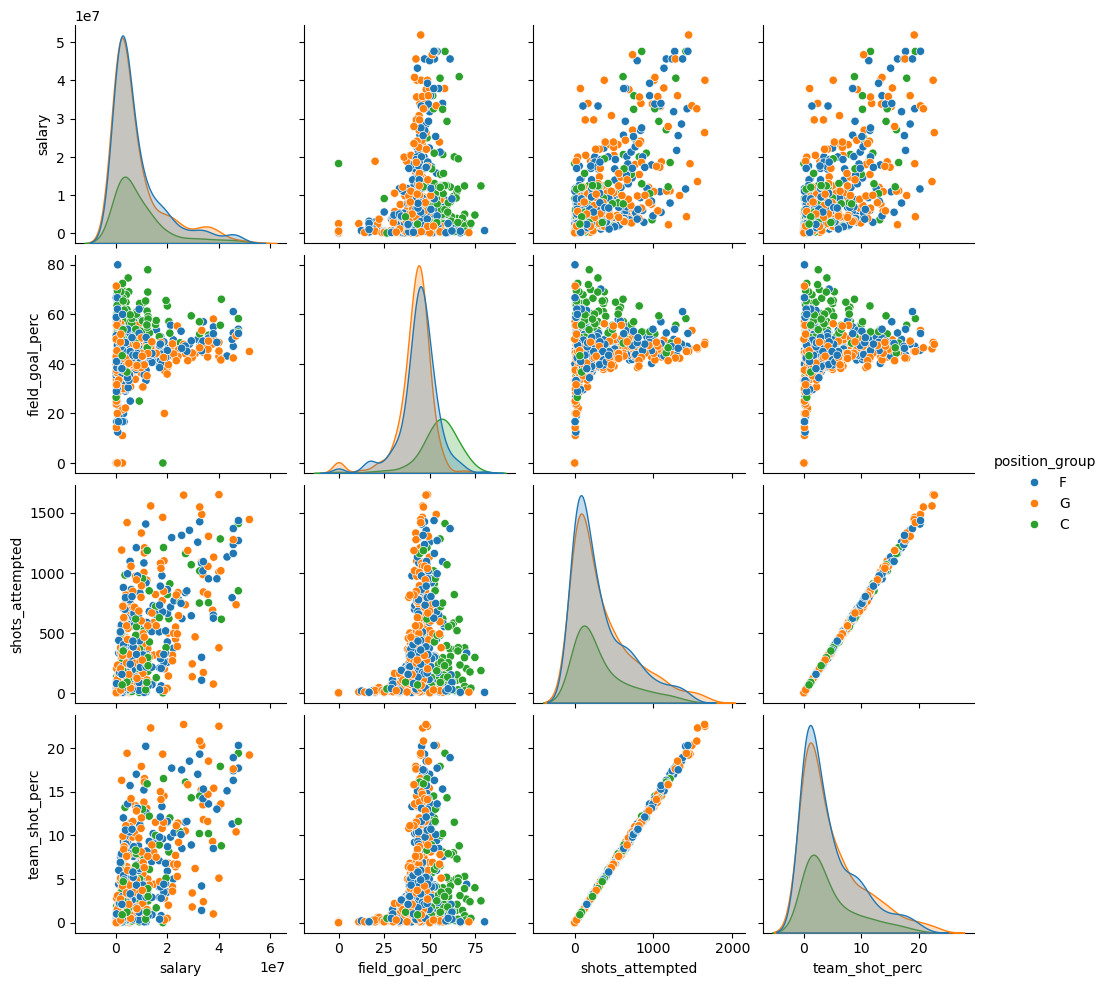

In [27]:
pp = sns.pairplot(df_scatter, hue = 'position_group')

Salary is right skewed as more players will be payed a lesser salary than the average.
field_goal_perc is mostly normally distributed.

field_goal_perc and shots_attempted are variables that worth looking into and how they are influenced by other variables in the dataset.  By understanding how these variables are correlated, we can understand what makes a good player

Additional Hypotheses Questions:
- How do players matchup at the team level? Are there variations to the shot types based on team/player preference?
- How does a team's composition affect their shot efficiency?
- Can a team's playstyle be deduced from the data? Faster/slower teams, etc?